In [1]:
from pathlib import Path
from typing import Dict, List, Tuple

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import scipy
import yaml
from skimage import transform

From the `fishsense_visualalign` tool, we have a file with the following information:
$$R = \left\{\vec{R_j} : 1 \leq j \leq m \right\}$$
where $R$ is the set of $m$ RGB tie points and
$$Z = \left\{\vec{Z_j} : 1 \leq j \leq m \right\}$$
where $Z$ is the set of $m$ depth tie points.

We wish to find a map $\mathbf{M}$ and vector $\vec{B}$ such that
$$Z = R\mathbf{M} + \vec{B}$$

where $$\mathbf{M}\mathbf{M}^T = r^2I$$

and $$\sum_{j=1}^m {\left|\vec{R_j}\mathbf{M} + \vec{B} - \vec{Z_j}\right|^2}$$ is minimized.

For this, we elect to represent $\vec{R}$ and $\vec{Z}$ as row vectors.

In [2]:
data_file_path = Path("D:\\160_bag\\calibration_data.yml")
with open(data_file_path) as f:
    data: Dict[str, Dict[str, List[Tuple[float, float]]]] = yaml.safe_load(f)

depth_points: List[np.ndarray] = []
rgb_points: List[np.ndarray] = []

for frame, frame_data in data.items():
    frame_depth_points = frame_data['depth']
    frame_rgb_points = frame_data['rgb']
    if len(frame_depth_points) != len(frame_rgb_points):
        continue
    depth_points.extend([np.array(l) for l in frame_depth_points])
    rgb_points.extend([np.array(l) for l in frame_rgb_points])
assert(len(depth_points) == len(rgb_points))
n_points = len(depth_points)
depth_points = np.array(depth_points)
rgb_points = np.array(rgb_points)

In [3]:
image_transform = transform.estimate_transform('affine', rgb_points, depth_points)

In [4]:
first_frame_key = list(data.keys())[0]
first_frame_path = Path(first_frame_key)

rgb_image_path = list(first_frame_path.glob('*.png'))[0]
depth_image_path = list(first_frame_path.glob('*.tiff'))[0]

rgb_image = cv.imread(rgb_image_path.as_posix())
depth_image = cv.imread(depth_image_path.as_posix(), -1)

first_frame_data = data[first_frame_key]

In [5]:
corrected_depth = scipy.ndimage.affine_transform(depth_image, np.linalg.inv(image_transform.params))

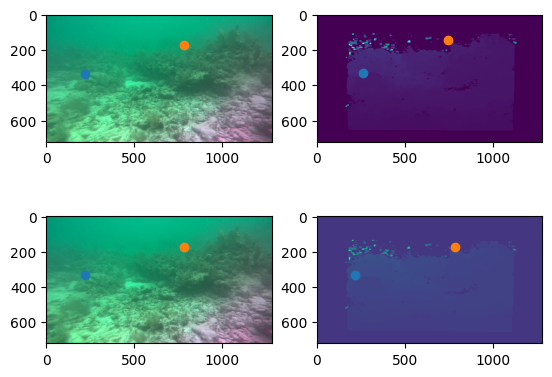

In [7]:
fig, ((rgb_ax1, depth_ax1), (rgb_ax2, depth_ax2)) = plt.subplots(nrows=2, ncols=2)
rgb_ax1.imshow(rgb_image)
rgb_ax2.imshow(rgb_image)
depth_ax1.imshow(depth_image)
depth_ax2.imshow(corrected_depth)

for point in first_frame_data['depth']:
    depth_ax1.scatter(point[0], point[1])

for point in first_frame_data['rgb']:
    rgb_ax1.scatter(point[0], point[1])
    rgb_ax2.scatter(point[0], point[1])
    depth_ax2.scatter(point[0], point[1])